In [1]:
%matplotlib inline
import sys
sys.path.append('../src')
from params import params as P
import numpy as np
import patch_sampling
from parallel import ParallelBatchIterator
np.random.seed(1)
P.DATA_LEVEL=0

train_generator, validation_generator = patch_sampling.prepare_sampler()

Loaded configurations from (in order) ['../src/../config/default.ini', '../src/../config/notebook.ini']


  0%|          | 0/36 [00:00<?, ?it/s]

OpenCV 2 NOT AVAILABLE, using skimage/scipy.ndimage instead
Loading validation masks


  0%|          | 0/9 [00:00<?, ?it/s]

Done in  6.40025305748
... is done
Loading train masks


100%|██████████| 9/9 [00:01<00:00,  6.68it/s]

Done in  1.61229419708
... is done


In [2]:
import util
import matplotlib.pyplot as plt
X_train = [1]*10

X_val = [1]*1
val_gen = ParallelBatchIterator(validation_generator, X_val, ordered=False,
                                                batch_size=1,
                                                multiprocess=False,
                                                n_producers=2)

train_gen = ParallelBatchIterator(train_generator, X_train, ordered=False,
                                                batch_size=1,
                                                multiprocess=False,
                                                n_producers=2)
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)



    


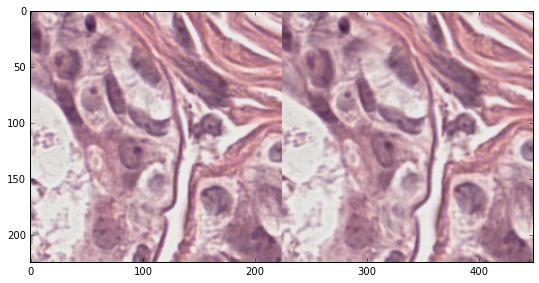

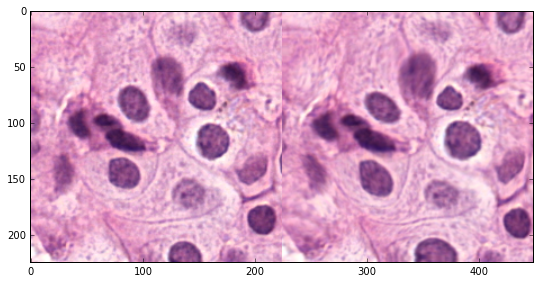

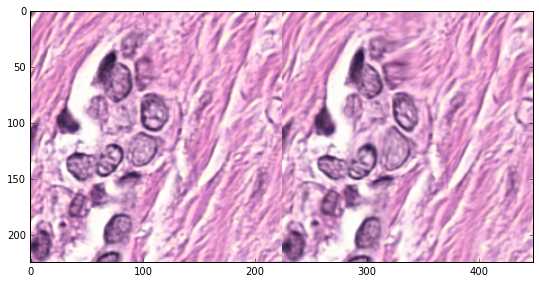

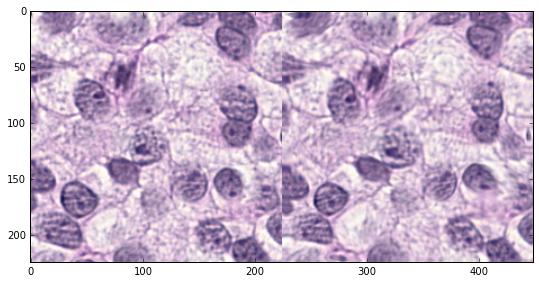

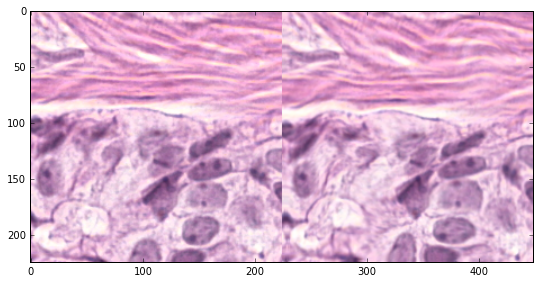

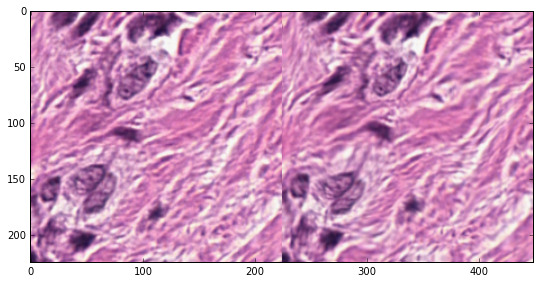

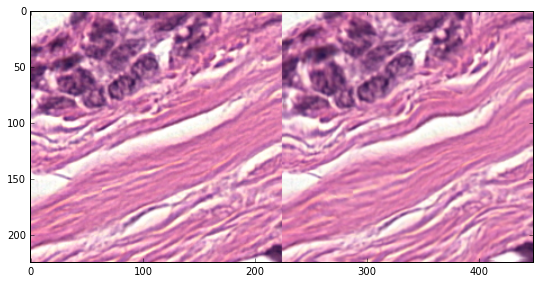

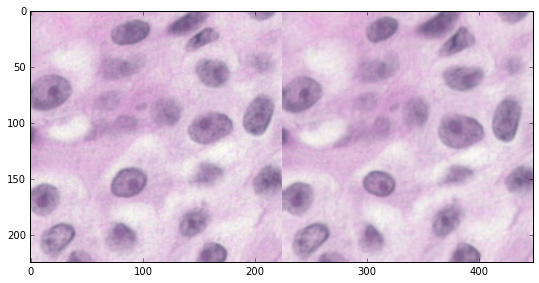

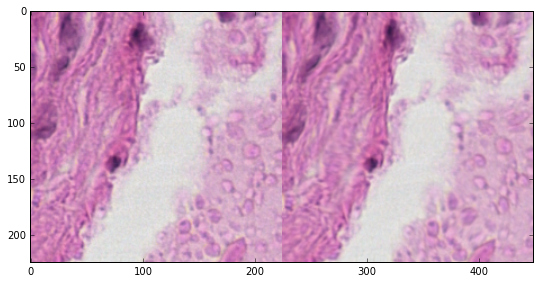

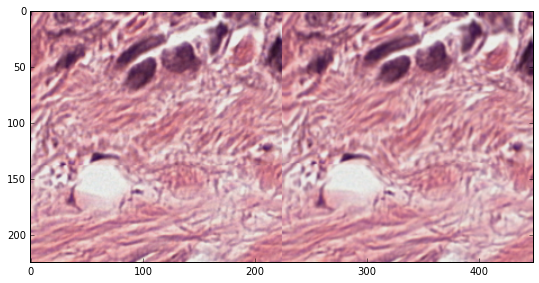

In [9]:
import skimage

def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[0], grid_size):
        rr,cc = skimage.draw.line(i, 0,i, im.shape[1]-1)
        im[rr, cc] = 255
    for j in range(0, im.shape[1], grid_size):
        rr,cc = skimage.draw.line(0, j, im.shape[0]-1, j)
        im[rr, cc] = 255
        
for batch in train_gen:
    images, labels = batch
    images = util.unzero_center(images, P.MEAN_PIXEL)
    
    im = images[0]*255
    im = im.transpose(1,2,0)

    
    #draw_grid(im, 24)
    el_im = elastic_transform(im, im.shape[0]*32, im.shape[0]*0.075)
    
    plt.figure(figsize = (9,5))
    plot_image = np.hstack((im/255, el_im/255))
    plt.imshow(plot_image)
    plt.show()
    
    
    